In [1]:

#%matplotlib tk
%matplotlib notebook
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os 
import matplotlib.animation as animation
import seaborn as sns
#%matplotlib inline



In [2]:
data_root = 'data/'
print(os.listdir(data_root))

['ghg-emissions.csv', 'history_data_20001231-20210227.csv', 'location_lookup.csv']


In [3]:
#temp data import 
temp_data_path = 'data/'+ 'history_data_20001231-20210227.csv'
temp_df= pd.read_csv(temp_data_path)
temp_df.head()


,location_id,date,maxTemp,minTemp,prcp
0,ST801,20010106,32.7,15.2,0.42
1,ST801,20010113,26.7,8.7,0.08
2,ST801,20010120,23.8,6.6,0.03
3,ST801,20010127,31.4,14.4,0.05
4,ST801,20010203,35.4,15.3,0.03


In [4]:

#location data 
location_path = data_root + 'location_lookup.csv'
loc_df = pd.read_csv(location_path)
loc_df.head()



,location_id,city,state_abbreviation,country_name,latitude,longitude
0,ST422,Edmonton,AB,CANADA,53.317,-113.583
1,ST500,Toronto,ON,CANADA,43.667,-79.633
2,ST515,Quebec,QC,CANADA,46.783,-71.367
3,ST593,Vancouver,BC,CANADA,49.200,-123.167
4,ST801,Beijing,NaN,CHINA,39.933,116.283


In [5]:

#merge the datasets together 
tempLocDf  = pd.merge(loc_df,temp_df,on="location_id")
print(tempLocDf.dtypes)
tempLocDf['date'] = pd.to_datetime(tempLocDf['date'],format='%Y%m%d')
tempLocDf.head()

location_id            object
city                   object
state_abbreviation     object
country_name           object
latitude              float64
longitude             float64
date                    int64
maxTemp               float64
minTemp               float64
prcp                  float64
dtype: object


,location_id,city,state_abbreviation,country_name,latitude,longitude,date,maxTemp,minTemp,prcp
0,ST422,Edmonton,AB,CANADA,53.317,-113.583,2001-01-06,38.2,19.4,0.02
1,ST422,Edmonton,AB,CANADA,53.317,-113.583,2001-01-13,35.7,11.3,0.00
2,ST422,Edmonton,AB,CANADA,53.317,-113.583,2001-01-20,32.7,10.4,0.03
3,ST422,Edmonton,AB,CANADA,53.317,-113.583,2001-01-27,35.9,10.1,0.00
4,ST422,Edmonton,AB,CANADA,53.317,-113.583,2001-02-03,37.7,17.6,0.02


In [6]:

#gas data 
gasDataPath = data_root + 'ghg-emissions.csv'
gasData = pd.read_csv(gasDataPath)
gasData.head()

,Country/Region,unit,1990,1991,1992,1993,1994,1995,1996,1997,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,China,MtCO2e,2901.74,3051.31,3182.64,3405.76,3556.72,3946.17,3980.46,3989.50,...,8398.83,8992.51,9828.01,10784.95,11110.34,11568.63,11583.36,11578.25,11577.98,11780.99
1,United States,MtCO2e,5669.57,5627.93,5709.22,5819.30,5906.34,5970.68,6069.33,6302.62,...,6267.37,5865.85,6111.83,6235.82,5936.10,6056.33,6097.71,5973.16,5833.01,5766.92
2,India,MtCO2e,1184.08,1239.12,1271.34,1303.07,1349.41,1415.03,1460.58,1519.01,...,2185.08,2339.28,2449.30,2798.04,2947.94,3003.54,3175.79,3188.03,3230.06,3356.70
3,Russia,MtCO2e,3559.43,3463.05,3223.12,2965.80,2682.65,2602.13,2508.31,2317.88,...,2616.58,2281.05,2401.69,2478.24,2598.33,2468.51,2479.35,2356.08,2434.46,2460.27
4,Indonesia,MtCO2e,1509.17,1526.51,1547.09,1563.34,1579.97,1610.76,1399.99,2386.18,...,2043.38,2478.22,2079.39,2335.30,2357.19,2294.34,2729.18,2776.53,2228.89,2275.40


In [7]:
#For intial Analysis we will only do Canada we can add more countries later. 
CanadaTemp = tempLocDf[tempLocDf["country_name"]=="CANADA"]
CanadaTemp.head()

,location_id,city,state_abbreviation,country_name,latitude,longitude,date,maxTemp,minTemp,prcp
0,ST422,Edmonton,AB,CANADA,53.317,-113.583,2001-01-06,38.2,19.4,0.02
1,ST422,Edmonton,AB,CANADA,53.317,-113.583,2001-01-13,35.7,11.3,0.00
2,ST422,Edmonton,AB,CANADA,53.317,-113.583,2001-01-20,32.7,10.4,0.03
3,ST422,Edmonton,AB,CANADA,53.317,-113.583,2001-01-27,35.9,10.1,0.00
4,ST422,Edmonton,AB,CANADA,53.317,-113.583,2001-02-03,37.7,17.6,0.02


<IPython.core.display.Javascript object>


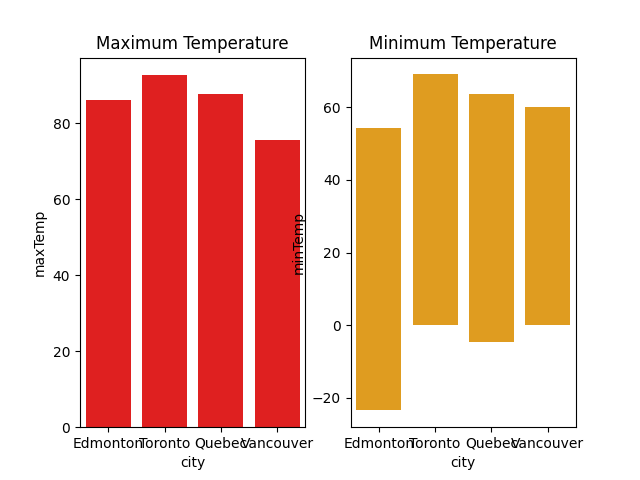

In [11]:
dates  = CanadaTemp.date.unique()
fig,ax = plt.subplots(1,2)

def animate(i):
    date = dates[i]
    currDateTemp = CanadaTemp[CanadaTemp["date"]==date]
    sns.barplot(ax=ax[0],y=currDateTemp["maxTemp"], x=currDateTemp["city"],data=currDateTemp,color="red")
    #title = ("Temperature Variation on: ", date)
    #print(title)
    #fig.suptitle(title)
    ax[0].set_title("Maximum Temperature")
    sns.barplot(ax=ax[1],y=currDateTemp["minTemp"], x=currDateTemp["city"],data=currDateTemp,color="orange")
    ax[1].set_title("Minimum Temperature")
    
ani = animation.FuncAnimation(fig,animate,frames=len(dates), repeat=True)
plt.show()